In [185]:
import urllib.request
import matplotlib.pyplot as plt
import os
import glob
from skimage.feature import hog
import cv2
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.applications.vgg16 import VGG16
import pickle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import collections

%matplotlib inline

In [6]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urllib.request.urlretrieve(url, file)
        print('Download Finished')
        
    else:
        print("File exists '{}' - skipping".format(file))


def draw_side_by_side(*images):
    cols = len(images)

    f, axes = plt.subplots(1, cols, figsize=(16, 6))
    f.tight_layout()
    f.subplots_adjust(left=-0.2, right=1, top=1., bottom=0., wspace=0., hspace=0.)

    if cols == 1:
        axes = [axes]

    for i in range(0,cols):
        a = axes[i]
        a.axis('off')
        a.imshow(images[i])

In [225]:
car_filenames = glob.glob('data_sample/vehicles*/**/*.*', recursive=True)
not_car_filenames = glob.glob('data_sample/non-vehicles*/**/*.*', recursive=True)

# car_filenames = glob.glob('data/vehicles*/**/*.*')
# not_car_filenames = glob.glob('data/non-vehicles*/**/*.*')


In [226]:
def load_images(filenames):
    return [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in filenames]

pick_every = 5
car_images = load_images(car_filenames[0::pick_every])
notcar_images = load_images(not_car_filenames[0::pick_every])
print('images loaded')

images loaded


In [227]:
print('car shape: ', car_images[0].shape)
print('notcar shape: ', notcar_images[0].shape)
print('Num cars: ', len(car_images))
print('Num notcars: ', len(notcar_images))
print('dtype: ', car_images[0].dtype)

car shape:  (64, 64, 3)
notcar shape:  (64, 64, 3)
Num cars:  240
Num notcars:  225
dtype:  uint8


# Color features

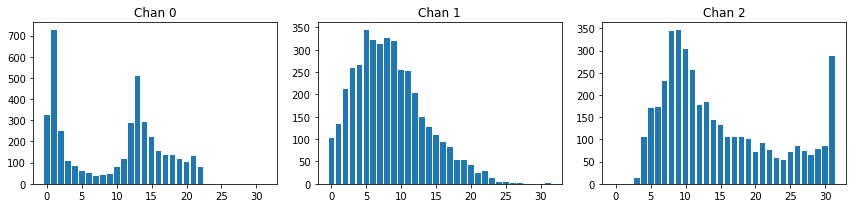

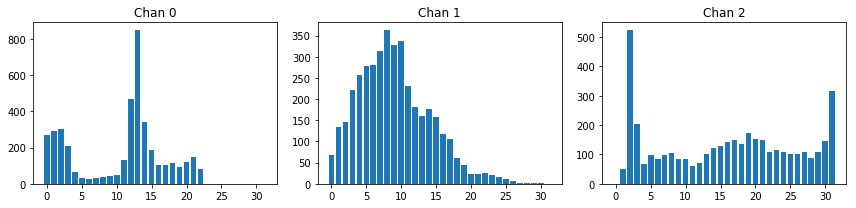

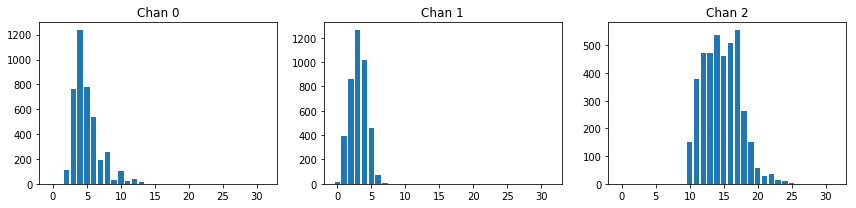

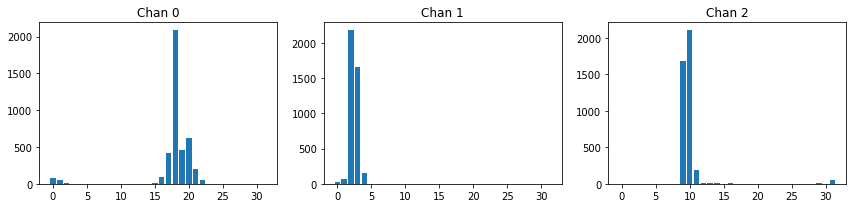

In [228]:
def convert_color(image, color_space='HSV', **kwargs):
    if color_space == 'HSV':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if color_space == 'LUV':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    if color_space == 'HLS':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if color_space == 'YUV':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    if color_space == 'YCrCb':
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    return image


def image_to_hist_features(image, nbins=32, bins_range=(0, 256), **kwargs):
    hist0 = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    hist1 = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    hist2 = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    hist_features = np.concatenate((hist0[0], hist1[0], hist2[0]))
    return hist_features
    

# Plot a figure with all three bar charts
def plot_hist(hist_features, nbins):
    x_vals = range(0, nbins)
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(x_vals, hist_features[0:nbins])
    plt.title('Chan 0')
    plt.subplot(132)
    plt.bar(x_vals, hist_features[nbins:2*nbins])
    plt.title('Chan 1')
    plt.subplot(133)
    plt.bar(x_vals, hist_features[2*nbins:])
    plt.title('Chan 2')
    fig.tight_layout()


def image_to_hist_plot(image):
    image = convert_color(image, 'HSV')
    hist_features = image_to_hist_features(image, nbins=32, bins_range=(0, 256))
    plot_hist(hist_features, 32)
    
image_to_hist_plot(car_images[0])
image_to_hist_plot(car_images[1])
image_to_hist_plot(notcar_images[0])
image_to_hist_plot(notcar_images[1])


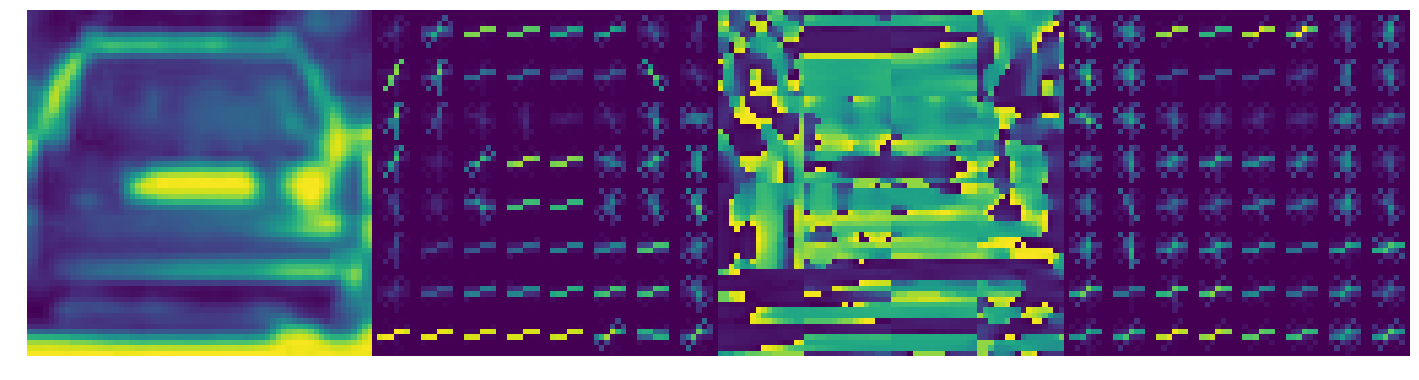

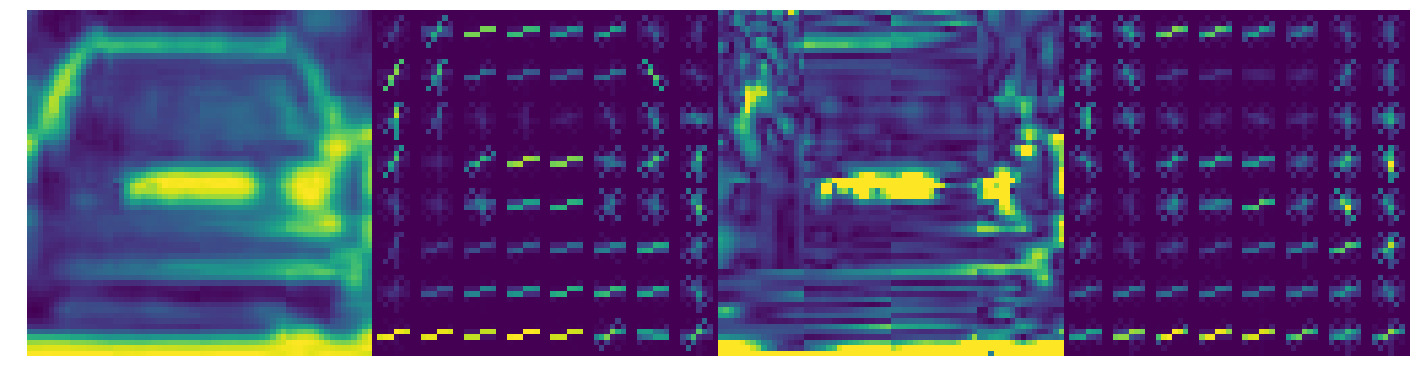

In [229]:
def image_to_hog(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vector=True, **kwargs):
    return hog(img, orientations=orient,
               pixels_per_cell=(pix_per_cell, pix_per_cell),
               cells_per_block=(cell_per_block, cell_per_block),
               visualise=vis, feature_vector=feature_vector,
               block_norm="L2-Hys")

gray = cv2.cvtColor(car_images[0], cv2.COLOR_RGB2GRAY)
hog_gray = image_to_hog(gray, 9, 8, 2, vis=True)[1]

hls = cv2.cvtColor(car_images[0], cv2.COLOR_RGB2HLS)
h = hls[:,:,0]
l = hls[:,:,1]
s = hls[:,:,2]

hog_h = image_to_hog(h, 9, 8, 2, vis=True)[1]
hog_l = image_to_hog(l, 9, 8, 2, vis=True)[1]
hog_s = image_to_hog(s, 9, 8, 2, vis=True)[1]

draw_side_by_side(gray, hog_gray, h, hog_h)
draw_side_by_side(l, hog_l, s, hog_s)


From the images it looks like grayscale or "L" is the best channel for HOG features. The H and S channels are not so clear.

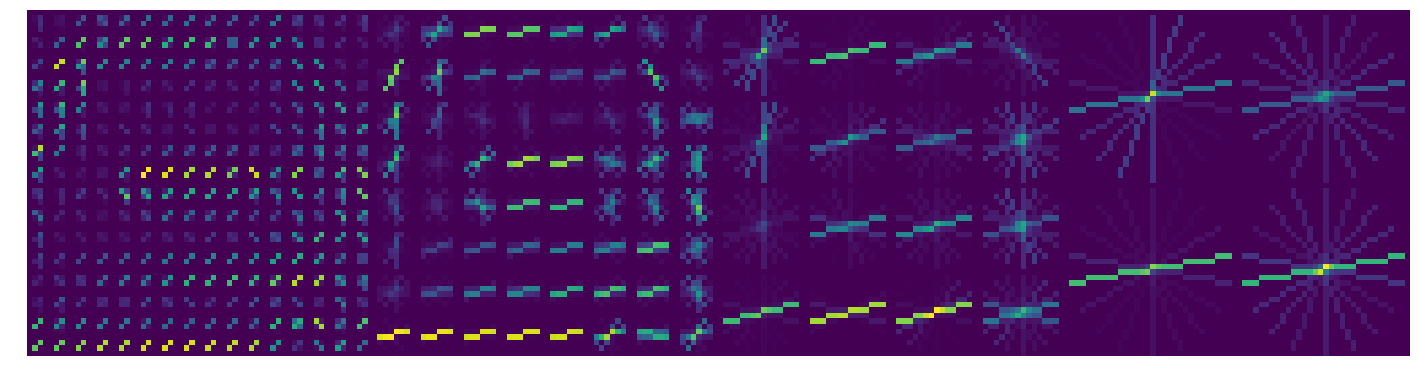

In [230]:
draw_side_by_side(
    image_to_hog(gray, orient=9, pix_per_cell=4, cell_per_block=2, vis=True)[1],
    image_to_hog(gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)[1],
    image_to_hog(gray, orient=9, pix_per_cell=16, cell_per_block=2, vis=True)[1],
    image_to_hog(gray, orient=9, pix_per_cell=32, cell_per_block=2, vis=True)[1],
)   

From the images above, it looks like the shape is visible in 4 and 8 pixels per cell, but not very visible at higher (16,32) pix per cell. Out of 4 or 8, 8 pixels per cell would have fewer features, which can be more robust (generalise better and be less prone to overfitting) as well be faster to pre-process, train and infer with.

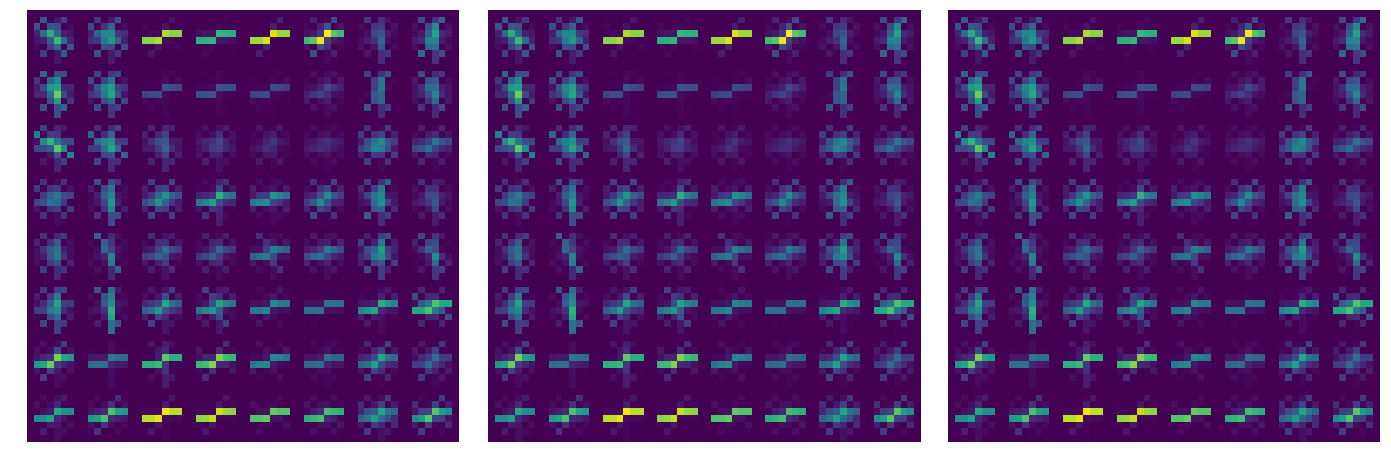

In [231]:
draw_side_by_side(
    image_to_hog(h, orient=9, pix_per_cell=8, cell_per_block=1, vis=True)[1],
    image_to_hog(h, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)[1],
    image_to_hog(h, orient=9, pix_per_cell=8, cell_per_block=4, vis=True)[1],
)

From the images above, I cannot see a difference with cell_per_block values. This makes sense as it would not be possible to draw the overlapped cells without taking another image to do so. To set this param I will have to use model training performance.

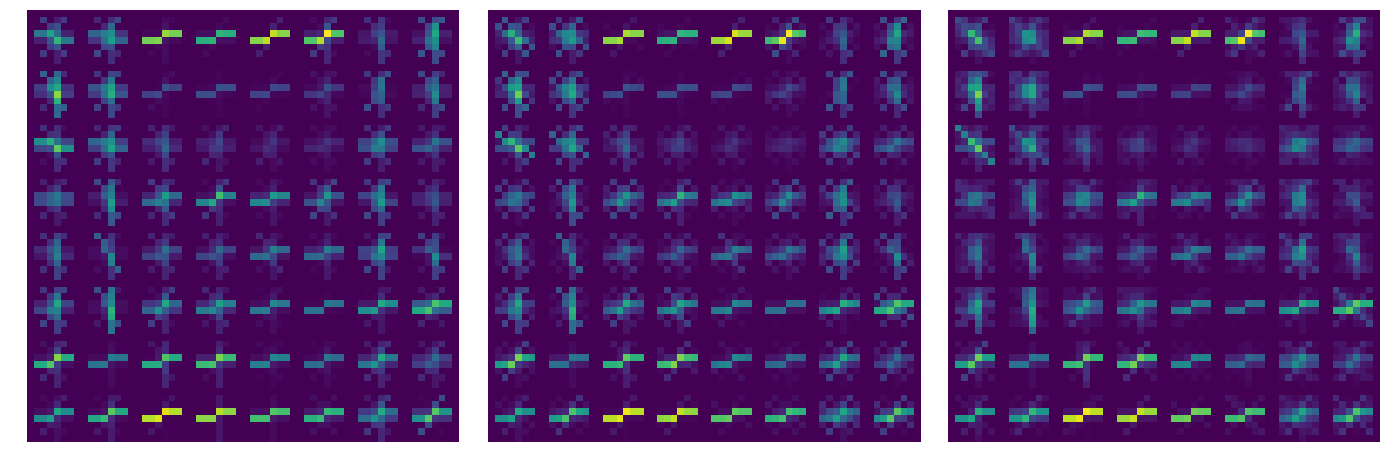

In [232]:
draw_side_by_side(
    image_to_hog(h, orient=5, pix_per_cell=8, cell_per_block=2, vis=True)[1],
    image_to_hog(h, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)[1],
    image_to_hog(h, orient=15, pix_per_cell=8, cell_per_block=2, vis=True)[1],
)

I can see the number of spokes in the star increase with more orientation bins. To set this param I will look at model training performance.


# Preprocessing the images for training




In [152]:
def image_to_color_hog(image, color_chan='ALL', feature_vector=True, **kwargs):
    if color_chan == 'ALL':
        image_hog = []
        for chan in range(image.shape[2]):
            chan_hog = image_to_hog(image[:, :, chan], **kwargs)
            image_hog.append(chan_hog)
        if feature_vector:
            image_hog = np.ravel(image_hog)
        else:
            image_hog = np.stack(image_hog)

    else:
        image_hog = image_to_hog(image[:, :, color_chan], **kwargs)
    return image_hog

def image_to_features(image, **kwargs):
    image = convert_color(image, **kwargs)
#     hist_features = image_to_hist_features(image, **kwargs)
    hog_features = image_to_color_hog(image)
    return hog_features
    return np.concatenate((hist_features, hog_features))

def images_to_features(images, **kwargs):
    return [image_to_features(image, **kwargs) for image in images]

def preprocess_data(car_images, notcar_images, **kwargs):
    print(kwargs)

    car_features = images_to_features(car_images, **kwargs)
    notcar_features = images_to_features(notcar_images, **kwargs)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    return X, y


# Training the model

The function below:

1. Pre-processes raw images according to the params passed - extracting the features.

2. Shuffles the data and splits the dataset into training and test datasets.

3. Scales the training data to ensure that different features (histogram of colours vs histogram of gradients) are not over/under weighted.

4. Trains a linear SVM on the training data

5. Calculates the accuracy on the test data

In [ ]:

def train_svm(car_images, notcar_images, **kwargs):
    X, y = preprocess_data(car_images, notcar_images, **kwargs)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_scaler = StandardScaler().fit(X_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    svc = SVC(C=1.0, kernel='linear')
    svc.fit(X_train, y_train)
    print('Test acc:', round(svc.score(X_test, y_test), 4))
    print('')
    
    return svc, X_scaler



# Tuning of HOG params based on model performance

I want to understand how model perfomance would change as I modify the different HOG params. However I have found that further adjustment is needed when looking at the test images, as they are different from the training set.

The performance (accuracy) below was calculated on the 'data_sample' folder images. Given more time I would repeat this search with the larger set of images.

### Color space choice

In [ ]:
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='RGB', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='HLS', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='HSV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan='ALL')

{'cell_per_block': 2, 'color_space': 'RGB', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 'ALL'}
Test acc: 0.9742

{'cell_per_block': 2, 'color_space': 'HLS', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 'ALL'}
Test acc: 0.9785

{'cell_per_block': 2, 'color_space': 'HSV', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 'ALL'}
Test acc: 0.9699

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 'ALL'}
Test acc: 0.9849

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 'ALL'}
Test acc: 0.9892

It looks like both LUV and YCrCb are good options for the color space.

### Color channel choice

In [154]:
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=0)
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=1)
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan=2)
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=0)
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=1)
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan=2)

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 0}
(2321, 1764)
X_train.shape:  (1856, 1764)
Test acc: 0.9505

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 1}
(2321, 1764)
X_train.shape:  (1856, 1764)
Test acc: 0.9548

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 2}
(2321, 1764)
X_train.shape:  (1856, 1764)
Test acc: 0.9699

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 0}
(2321, 1764)
X_train.shape:  (1856, 1764)
Test acc: 0.9527

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 1}
(2321, 1764)
X_train.shape:  (1856, 1764)
Test acc: 0.9656

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 2}
(2321, 1764)
X_train.shape:  (1856, 1764)
Test acc: 0.9656

It looks like using all three channels gives better accuracy

### Number of orients choice

In [155]:
# train_svm(car_images, notcar_images, orient=7, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=8, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=11, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 7, 'color_chan': 'ALL'}
Test acc: 0.9763

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 8, 'color_chan': 'ALL'}
Test acc: 0.9828

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 9, 'color_chan': 'ALL'}
Test acc: 0.9849

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 11, 'color_chan': 'ALL'}
Test acc: 0.9892

It looks like more orients are better, however the difference levels off at 9/10. I will choose 9 and adjust further later. As few as I can get away with would probably be better, as this would reduce chance of overfitting.


### Pixels per cell

In [156]:
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=4, cell_per_block=2, color_space='YCrCb', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=16, cell_per_block=2, color_space='YCrCb', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=32, cell_per_block=2, color_space='YCrCb', color_chan='ALL')

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 4, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9892

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 16, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9892

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 32, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9871

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 4, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 16, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 32, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9871

I will choose 8 pizels per cell - this is based on model performance and visual inspection of the HOG above at different values. 

### Cell per block choice

In [ ]:
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=1, color_space='YCrCb', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=2, color_space='YCrCb', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=8, cell_per_block=4, color_space='YCrCb', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=16, cell_per_block=1, color_space='YCrCb', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=16, cell_per_block=2, color_space='YCrCb', color_chan='ALL')
# train_svm(car_images, notcar_images, orient=10, pix_per_cell=16, cell_per_block=4, color_space='YCrCb', color_chan='ALL')

{'cell_per_block': 1, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9806

{'cell_per_block': 2, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 4, 'color_space': 'LUV', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 1, 'color_space': 'YCrCb', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9806

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 4, 'color_space': 'YCrCb', 'pix_per_cell': 8, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9935

{'cell_per_block': 1, 'color_space': 'YCrCb', 'pix_per_cell': 16, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9742

{'cell_per_block': 2, 'color_space': 'YCrCb', 'pix_per_cell': 16, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

{'cell_per_block': 4, 'color_space': 'YCrCb', 'pix_per_cell': 16, 'orient': 10, 'color_chan': 'ALL'}
Test acc: 0.9914

I will choose 2 cells per block

### Hyperparams Tuning

There are also params relating to the SVM classifier. Choice of kernel and values for the C param (how strongly mislabelled data is penalized). I will use the sklearn GridSearchCV to search values

In [158]:
# X, y = preprocess_data(car_images, notcar_images, orient=9, pix_per_cell=8, cell_per_block=2, color_space='LUV', color_chan='ALL')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_scaler = StandardScaler().fit(X_train)
# X_train = X_scaler.transform(X_train)
# X_test = X_scaler.transform(X_test)

# # Set the parameters by cross-validation
# tuned_parameters = [
#     {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#     {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]

# print("# Tuning hyper-parameters")
# print()

# clf = GridSearchCV(SVC(), tuned_parameters, cv=3)
# clf.fit(X_train, y_train)

# print("Best parameters set found on development set:")
# print(clf.best_params_)
# print("Grid scores on development set:")
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))

# print('Final Acc:', clf.score(X_test, y_test))



I will stay with linear kernel with C=1.0

# Final Model Params

These are kept here to retweak if needed as I look at the test images.

In [159]:
model_params = {
    'orient': 11,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'color_space': 'LUV',
    'color_chan': 'ALL',
    'nbins': 16,
    'bins_range': (0, 256)
}

model, scaler = train_svm(car_images, notcar_images, **model_params)

{'cell_per_block': 2, 'orient': 11, 'bins_range': (0, 256), 'color_chan': 'ALL', 'nbins': 16, 'color_space': 'LUV', 'pix_per_cell': 8}
Test acc: 0.9733



In [161]:
filename = 'model_v3.pkl'
model_cp = model
pickle.dump(model, open(filename, 'wb'))

In [162]:
model = pickle.load(open(filename, 'rb'))

# Helper functions

The `is_car` function takes a window (to be used in the sliding window search) and does the following:
1. Resizes to 64x64 pixels - as this is what was used to train the model, the input at inference time must be the same as at training time.
2. Calculates the features needed - color bins, HOG (same as during training)
3. Scales the features
4. Calls the model to make a prediction
5. Thresholds the score. The default prediction had too many false positives, this thresholding helps later.

In [163]:
def is_car(window_pixels, model_size=64):
    window_pixels_resized = cv2.resize(window_pixels, (model_size, model_size))
#     window_pixels_resized = window_pixels

    features = images_to_features([window_pixels_resized], **model_params)
    window_X = np.vstack(features)
    window_X = scaler.transform(window_X)
    pred = model.decision_function(window_X)[0]
    
#     print(window_pixels.shape)
#     print(window_pixels_resized.shape)
#     print(window_X.shape)
#     print(pred)
    return pred > 0.4

# draw_side_by_side(car_images[0], notcar_images[0])

is_car(car_images[0])
is_car(car_images[1])
is_car(car_images[2])
is_car(car_images[3])

is_car(notcar_images[0])
is_car(notcar_images[1])
is_car(notcar_images[2])
is_car(notcar_images[3])

False

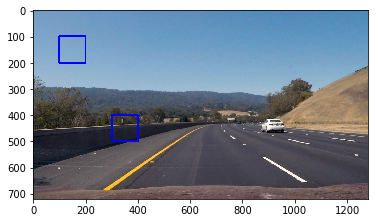

In [165]:
test3 = plt.imread('test_images/test3.jpg')

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    for box in bboxes:
        x = (box[0], box[1])
        y = (box[2], box[3])
        cv2.rectangle(draw_img, x, y, color, thick)
    return draw_img 

bboxes = [[100,100,200,200], [300, 400, 400, 500]]

result = draw_boxes(test3, bboxes)
plt.imshow(result)

# Sliding window search

The function below loops through different window sizes and slides them over the image. On every iteration the pixels under the window are passed to the `is_car` function. 

1. The `window_sizes` array determines the different zoom levels - for near and far vehicles.
2. The `window_step_frac` determines how much the window is moved between iterations. 0.2 means it is shifted by 20% of the window size
3. The `start_height` is used to skip searching in the top half of the images where there aren't likely to be any cars (TODO: update this param once flying cars are invented)!
4. The `window_rows` function is used to minimise the numebr of rows of searching that is performed. Each element in the array corresponds to the number of rows that is searched for that window size.



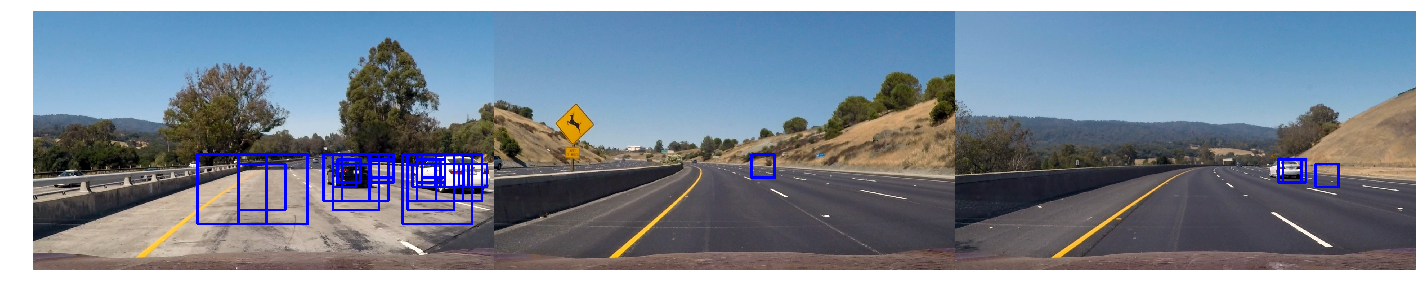

In [168]:
def filename_to_image(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

def image_to_bboxes(image):
    width = 1280
    height = 720
    start_height = 400
    window_step_frac = 0.2
    window_rows = [3,2,1]
    window_sizes = [64, 128, 192]
    pix_per_cell = model_params['pix_per_cell']
    cell_per_block = model_params['cell_per_block']

    bboxes = []
    
#     whole_hog_image = image_to_color_hog(image, **model_params)
    
#     print(whole_hog_image.shape)
    
#     hog_image = hog(image, orientations=orient,
#                     pixels_per_cell=(pix_per_cell, pix_per_cell),
#                     cells_per_block=(cell_per_block, cell_per_block),
#                     visualise=False, feature_vector=False)

    for i in range(0,len(window_sizes)):
        window_size = window_sizes[i]
        window_step = round(window_size * window_step_frac)
                   
        for y in range(start_height, start_height + window_rows[i]*window_step, window_step):
            for x in range(0, width-window_size, window_step):

                window_pixels = image[y:y+window_size, x:x+window_size, :]
                if is_car(window_pixels):
                    bboxes.append( 
                        [x, y, x+window_size, y+window_size]
                    )
    return bboxes


def filename_to_bboxes(filename):
    image = filename_to_image(filename)
    bboxes = image_to_bboxes(image)
#     bboxes, weights = cv2.groupRectangles(bboxes, 1, 0.2)
    return draw_boxes(image, bboxes)

draw_side_by_side(
    filename_to_bboxes('test_images/test1.jpg'),
    filename_to_bboxes('test_images/test2.jpg'),
    filename_to_bboxes('test_images/test3.jpg'),
)


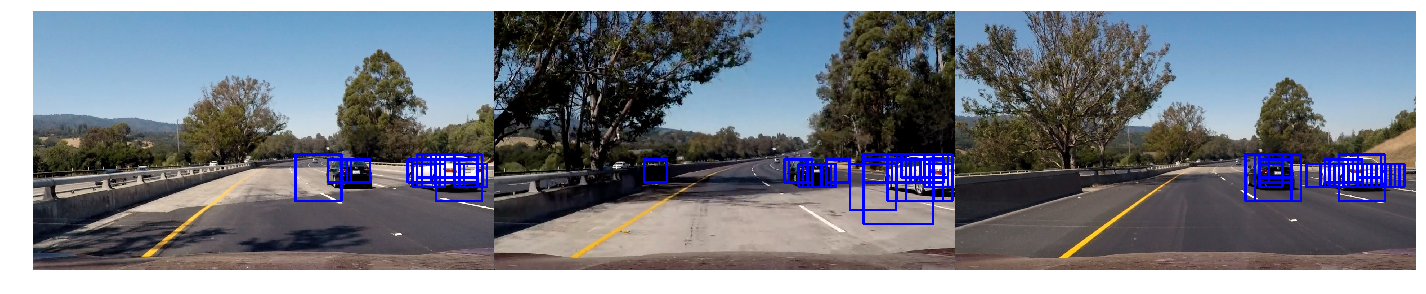

In [169]:
draw_side_by_side(
    filename_to_bboxes('test_images/test4.jpg'),
    filename_to_bboxes('test_images/test5.jpg'),
    filename_to_bboxes('test_images/test6.jpg'),
)

In the images above I see the cars are detected by the classifier, however there are a number of false positives. These occur on regions containing detail (e.g. road surface has texture) which I believe is creating a HOG pattern that mimics the car. The false posives were worse, I have tuned the model params (such as the decision function threshold) to reduce these.


# Removing false positives & duplicates

By summing up detections into a heatmap and thresholding I will try to both eliminate false positives (detections where there is no real car) and duplicates (multiple detections of the same car).


3 cars found
0 cars found
1 cars found


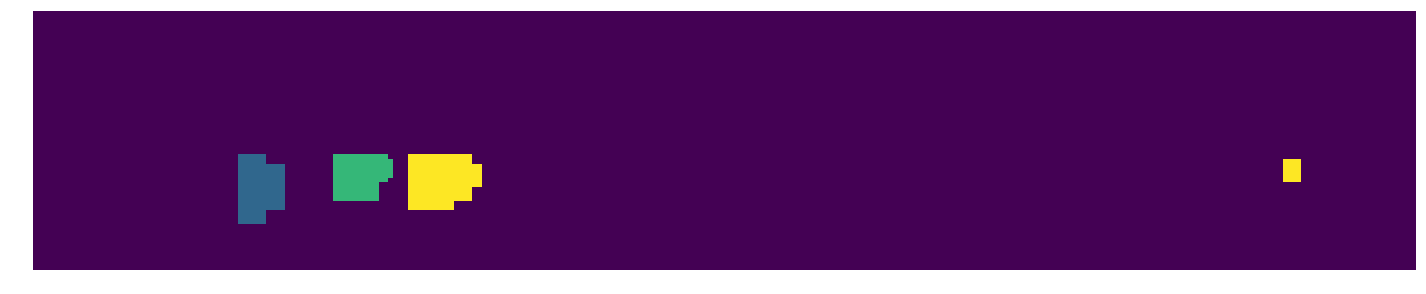

In [197]:
def bboxes_to_heatmap(bboxes, image):
    heatmap_shape = image.shape[:2]
    heatmap = np.zeros(heatmap_shape)
    
    for bbox in bboxes:
        heatmap[bbox[1]:bbox[3], bbox[0]:bbox[2]] += 1
    return heatmap

def threshold_heatmap(heatmap, threshold = 1):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def filename_to_heatmap(filename):
    from scipy.ndimage.measurements import label

    image = filename_to_image(filename)
    bboxes = image_to_bboxes(image)
    heatmap = bboxes_to_heatmap(bboxes, image)
    heatmap = threshold_heatmap(heatmap)
    labels = label(heatmap)
    print(labels[1], 'cars found')
    return labels

draw_side_by_side(
    filename_to_heatmap('test_images/test1.jpg')[0],
    filename_to_heatmap('test_images/test2.jpg')[0],
    filename_to_heatmap('test_images/test3.jpg')[0],
)


3 cars found
2 cars found
2 cars found


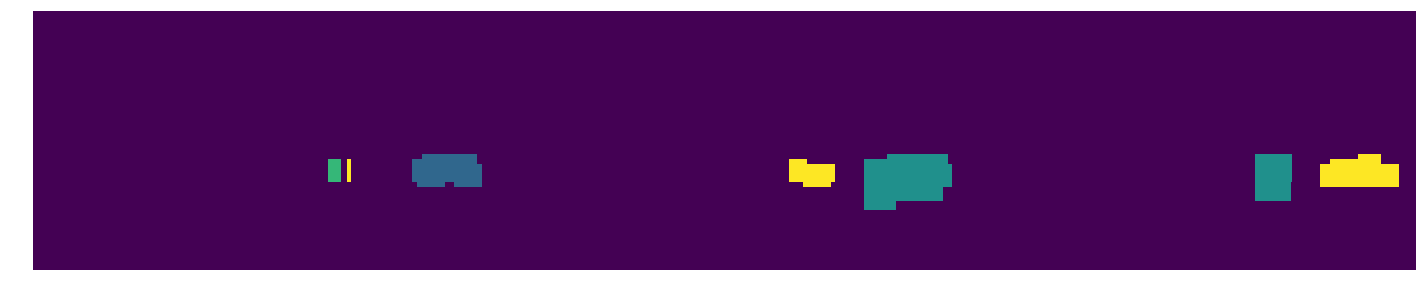

In [198]:

draw_side_by_side(
    filename_to_heatmap('test_images/test4.jpg')[0],
    filename_to_heatmap('test_images/test5.jpg')[0],
    filename_to_heatmap('test_images/test6.jpg')[0],
)

It is still the case that occasional false negatives are picked up. There is a trade off:
- Setting the threshold high removes false positives but also means that distant cars are not picked up.
- Setting the threshold low means more false positives but distant cars are not lost.

Perhaps given more time I could use smaller window scales, or more data to try improve model performace.
I hope that I can eliminate more false positives by smoothing in time during video processing.

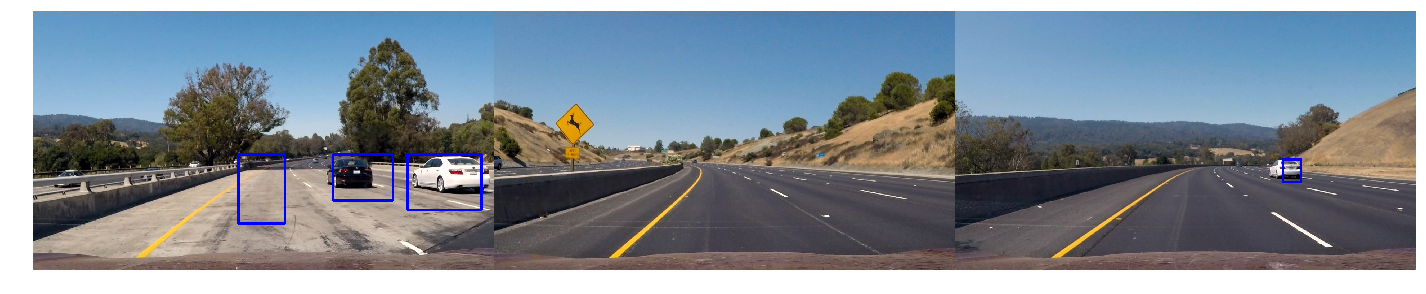

In [199]:
def labels_to_bboxes(labels):
    bboxes = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = [np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)]
        bboxes.append(bbox)
    return bboxes

def filename_to_labeled_box(filename):
    image = filename_to_image(filename)
    bboxes = image_to_bboxes(image)
    heatmap = bboxes_to_heatmap(bboxes, image)
    heatmap = threshold_heatmap(heatmap)
    labels = label(heatmap)
    label_bboxes = labels_to_bboxes(labels)
    return draw_boxes(image, label_bboxes)

draw_side_by_side(
    filename_to_labeled_box('test_images/test1.jpg'),
    filename_to_labeled_box('test_images/test2.jpg'),
    filename_to_labeled_box('test_images/test3.jpg'),
)


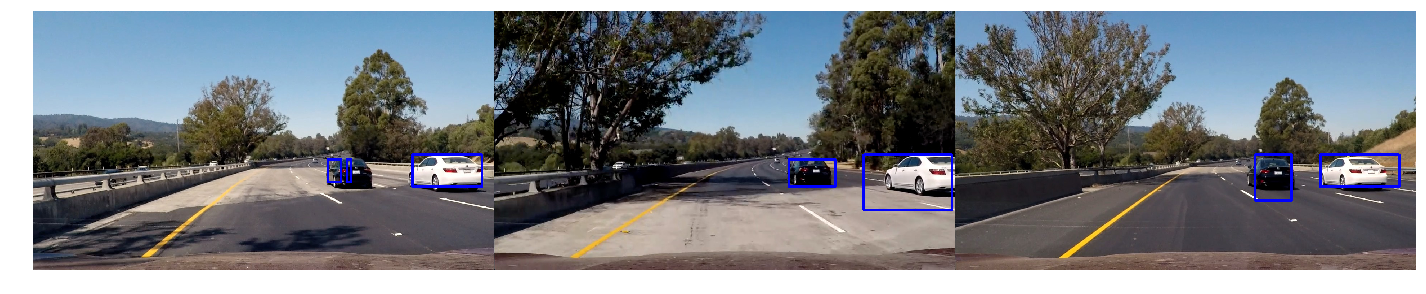

In [200]:

draw_side_by_side(
    filename_to_labeled_box('test_images/test4.jpg'),
    filename_to_labeled_box('test_images/test5.jpg'),
    filename_to_labeled_box('test_images/test6.jpg'),
)


Above I have created functions which draw boxes around the non-rectangular heatmap regions.

In [201]:

# image = filename_to_image('test_images/test4.jpg')
# bboxes = image_to_bboxes(image)
# heatmap = bboxes_to_heatmap(bboxes, image)


In [ ]:
# heatmap_history = collections.deque(maxlen=10)

# heatmap_history.append(heatmap)
# sum1 = sum(heatmap_history)
# sum1 = threshold_heatmap(sum1)

# heatmap_history.append(heatmap)
# heatmap_history.append(heatmap)
# heatmap_history.append(heatmap)
# heatmap_history.append(heatmap)
# heatmap_history.append(heatmap)
# heatmap_history.append(heatmap)
# sum2 = sum(heatmap_history)
# sum2 = threshold_heatmap(sum2)

# draw_side_by_side(sum1, sum2)

# Final pipeline

Below is the final pipeline. It contains an additional time smoothing step. I use a queue of a set length to record the heatmap at each frame. The entire queue is summed up to get the heatmap across many frames. This handles situations where a false positive is only detected for a short time - it won't have enough "heat" over many frames if it is transitory.

The threshold is then taken after the heatmaps are summed up.

In [214]:
heatmap_history = collections.deque(maxlen=20)

def find_cars(image):
    bboxes = image_to_bboxes(image)
    heatmap = bboxes_to_heatmap(bboxes, image)
    heatmap_history.append(heatmap)
    heatmap_sum = sum(heatmap_history)
    heatmap_sum = threshold_heatmap(heatmap_sum, threshold=40)
    labels = label(heatmap_sum)
    label_bboxes = labels_to_bboxes(labels)
    return draw_boxes(image, label_bboxes)
    



In [215]:
heatmap_history = collections.deque(maxlen=10)

project_video = VideoFileClip('test_video.mp4')
project_output = project_video.fl_image(find_cars)
output_filename = 'test_video_output6_history20_thresh40.mp4'
if os.path.exists(output_filename):
    raise Error('file_exits')
else:
    %time project_output.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video test_video_output6_history20_thresh40.mp4
[MoviePy] Writing video test_video_output6_history20_thresh40.mp4


 97%|█████████▋| 38/39 [01:52<00:02,  2.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output6_history20_thresh40.mp4 

CPU times: user 1min 51s, sys: 210 ms, total: 1min 51s
Wall time: 1min 53s


In [216]:
heatmap_history = collections.deque(maxlen=10)

project_video = VideoFileClip('project_video.mp4')
project_output = project_video.fl_image(find_cars)
output_filename = 'project_video_output2_history20_thresh40.mp4'
if os.path.exists(output_filename):
    raise Error('file_exits')
else:
    %time project_output.write_videofile(output_filename, audio=False)

[MoviePy] >>>> Building video project_video_output2_history20_thresh40.mp4
[MoviePy] Writing video project_video_output2_history20_thresh40.mp4


100%|█████████▉| 1260/1261 [1:01:08<00:02,  2.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2_history20_thresh40.mp4 

CPU times: user 1h 43s, sys: 6.73 s, total: 1h 50s
Wall time: 1h 1min 9s


# Discussion

Challenges & improvements
1. Choosing the params (both pre-processing and model hyperparams) was time consuming. It also was not indicative of performance on the video. E.g. using sample data gave accuracies of over 99% but gave many false positives. If I was to do this again I would do a "tracer bullet" end to end workflow to have more awareness of the issues later on and spend less time tuning params based on training/test accuracy.

2. Tuning of the params based on the few test images also proved flaky - when the test video was processed there were many false positives. Again getting a workflow that produced a test video when changes were made would help review.

3. The training dataset contained many adjacent frames of nearly identical images. This, combined with the fact I used the sklearn `train_test_split` meant that my training and test datasets contained similar images, which could be leading to overfitting. If I had more time I would like to sort the data to ensure that similar images are grouped one of training or test sets.

4. The pre-processing takes a long time. I am calculating the HOG features once for every window even though there is overlap. This is an improvement (HOG subsampling) I would do to improve performace.

5. I would like to explore other models (deep neural networks) to see how they compare in terms of performace and inference speed.

6. The model doesn't handle overlapping cars well, and merges them into one "blob". Perhaps by using car color (only grouping detections that have the same color) this could be handled.

7. The pipeline is a maximum-likelihood approach and doesn't map the car to the "world". There is no sense of prior probablility of a car existing in that area. As drivers we know (due to our knowledge that cars drive on the surface of the road in lanes) that cars are only likely to appear in certain aread. If we see a picture of a car on a billboard to the side of the road, no matter how realistic it is, we know it is unlikely to be a real car as it is not on the road. This would fool the pipeline however!